In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = pd.read_csv("../data/train/train_feature.csv", index_col='id')
dataset.head()

,num_orders,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,city_code,region_code,center_type,op_area,category,cuisine,discount,year,month,week_in_month
id,,,,,,,,,,,,,,,,,,
1379560,177,1,55,1885,136.83,152.29,0,0,647,56,TYPE_C,2.0,Beverages,Thai,15.46,1,1,1
1466964,270,1,55,1993,136.83,135.83,0,0,647,56,TYPE_C,2.0,Beverages,Thai,-1.00,1,1,1
1346989,189,1,55,2539,134.86,135.86,0,0,647,56,TYPE_C,2.0,Beverages,Thai,1.00,1,1,1
1338232,54,1,55,2139,339.50,437.53,0,0,647,56,TYPE_C,2.0,Beverages,Indian,98.03,1,1,1
1448490,40,1,55,2631,243.50,242.50,0,0,647,56,TYPE_C,2.0,Beverages,Indian,-1.00,1,1,1


In [3]:
categorical_columns = ['week', 'center_id', 'meal_id', 'emailer_for_promotion', 'homepage_featured', 'city_code', 
                       'region_code', 'center_type', 'category', 'cuisine','year','month','week_in_month']
for column in categorical_columns:
    dataset[column] = dataset[column].astype('category')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 1379560 to 1361984
Data columns (total 18 columns):
num_orders               456548 non-null int64
week                     456548 non-null category
center_id                456548 non-null category
meal_id                  456548 non-null category
checkout_price           456548 non-null float64
base_price               456548 non-null float64
emailer_for_promotion    456548 non-null category
homepage_featured        456548 non-null category
city_code                456548 non-null category
region_code              456548 non-null category
center_type              456548 non-null category
op_area                  456548 non-null float64
category                 456548 non-null category
cuisine                  456548 non-null category
discount                 456548 non-null float64
year                     456548 non-null category
month                    456548 non-null category
week_in_month            456548 non-nul

# Correlation between variables

In [4]:
correlation = dataset.corr()
correlation

,num_orders,checkout_price,base_price,op_area,discount
num_orders,1.000000,-0.282108,-0.222306,0.176976,0.152950
checkout_price,-0.282108,1.000000,0.953389,0.021569,0.005878
base_price,-0.222306,0.953389,1.000000,0.018031,0.307343
op_area,0.176976,0.021569,0.018031,1.000000,-0.008267
discount,0.152950,0.005878,0.307343,-0.008267,1.000000


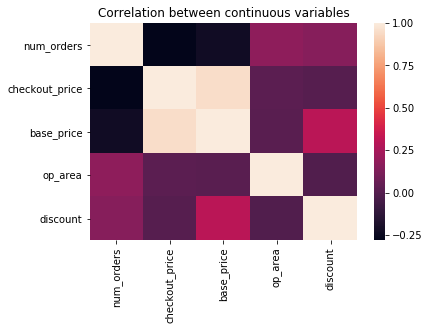

In [5]:
_ = sns.heatmap(correlation)
_ = plt.title("Correlation between continuous variables")
plt.show()

<p>The checkout price and base price has high positive correlation with each other and negative correlation with number of orders. It make sense, customer will order cheaper meals more than costly meals.</p>
<p>The operating area and discount has low positive correlation with other variables.</p>

# Promotion Activity

In [6]:
# Function to draw samples, it will be used in performing tests
def draw_samples(series, statistic=np.mean, replicas=10000):
    size = series.shape[0]
    sample_data = [statistic(series.sample(n=size, replace=True)) for _ in range(replicas)]
    return np.array(sample_data)

In [7]:
promotion = dataset['emailer_for_promotion'].astype('int') + dataset['homepage_featured'].astype('int')
promotion.value_counts()

0    388874
1     48443
2     19231
dtype: int64

In the dataset, there are two types of promotional activity, viz. promotion by emails and promotion in homepage of website. Sometimes both activities were performed but most of the time any one was performed. Due to this, below questions are raised:
1. Does promotion by email results in increase in number of orders ?
2. Does promotion in homepage results in increase in number of orders ?
3. Since, there are activity in any one way, which promotional activity has higher impact on number of orders?

### Does promotion by email results in increase in number of orders ?

<p>Let's perform hypothesis test to answer this question.</p>
<p><b>Null Hypothesis: </b><i>The difference between the mean of number of orders with email promotion and without email promotion is less than or equal to zero.</i></p>
<p><b>Alternate Hypothesis: </b><i>The difference between the mean of number of orders with email promotion and without email promotion is greater than zero.</i></p>

Observed mean difference: 401.83466060394824
Confidence Intervals: [394.26204055]
P-value: 0.0


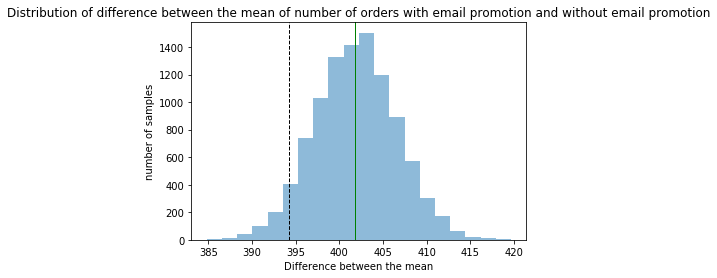

In [8]:
emailer_orders = dataset[dataset.emailer_for_promotion == 1]['num_orders']
non_emailer_orders = dataset[dataset.emailer_for_promotion == 0]['num_orders']

observed_mean_diff = emailer_orders.mean() - non_emailer_orders.mean()
mean_diff_bootstrap = draw_samples(emailer_orders) - draw_samples(non_emailer_orders)

confidence_interval = np.percentile(mean_diff_bootstrap, [5.0])
p_value = np.sum(mean_diff_bootstrap <= 0)/ len(mean_diff_bootstrap)

print("Observed mean difference: {}".format(observed_mean_diff))
print("Confidence Intervals: {}".format(confidence_interval))
print("P-value: {}".format(p_value))

# Plotting histogram
_ = plt.hist(mean_diff_bootstrap, bins=20, alpha=0.5)
_ = plt.xlabel("Difference between the mean")
_ = plt.ylabel("number of samples")
_ = plt.title("Distribution of difference between the mean of number of orders with email promotion and without email promotion")

# Marking the 5% confidence interval
_ = plt.axvline(confidence_interval[0], color='k', linestyle='dashed', linewidth=1)
_ = plt.axvline(observed_mean_diff, color='g', linewidth=1)

plt.show()

<p>The P-value of above hypothesis test is statistically significant for given left-side 0.05 alpha. Hence, we reject the null hypothesis and accept the alternative hypothesis.</p>
<p>The above Histogram also supports alternate hypothesis.</p>
<p><b><i>Conclusion:</i> Promotion Activity by emails does increase the number of orders</b></p>

### Does promotion in homepage results in increase in number of orders ?

<p>Let's perform hypothesis test to answer this question.</p>
<p><b>Null Hypothesis: </b><i>The difference between the mean of number of orders with homepage promotion and without homepage promotion is less than or equal to zero.</i></p>
<p><b>Alternate Hypothesis: </b><i>The difference between the mean of number of orders with homepage promotion and without homepage promotion is greater than zero.</i></p>

Observed mean difference: 373.8347456767344
Confidence Intervals: [367.91275022]
P-value: 0.0


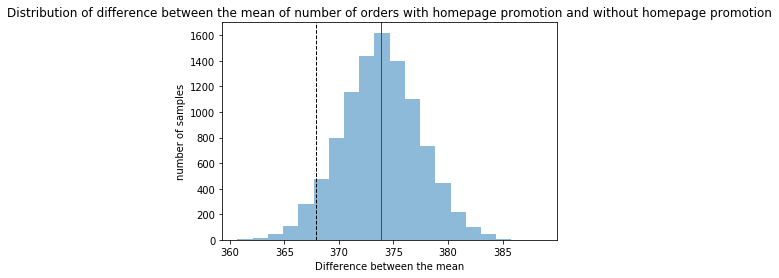

In [9]:
homepage_orders = dataset[dataset.homepage_featured == 1]['num_orders']
non_homepage_orders = dataset[dataset.homepage_featured == 0]['num_orders']

observed_mean_diff = homepage_orders.mean() - non_homepage_orders.mean()
mean_diff_bootstrap = draw_samples(homepage_orders) - draw_samples(non_homepage_orders)

confidence_interval = np.percentile(mean_diff_bootstrap, [5.0])
p_value = np.sum(mean_diff_bootstrap <= 0)/ len(mean_diff_bootstrap)

print("Observed mean difference: {}".format(observed_mean_diff))
print("Confidence Intervals: {}".format(confidence_interval))
print("P-value: {}".format(p_value))

# Plotting histogram
_ = plt.hist(mean_diff_bootstrap, bins=20, alpha=0.5)
_ = plt.xlabel("Difference between the mean")
_ = plt.ylabel("number of samples")
_ = plt.title("Distribution of difference between the mean of number of orders with homepage promotion and without homepage promotion")

# Marking the 5% confidence interval
_ = plt.axvline(confidence_interval[0], color='k', linestyle='dashed', linewidth=1)
_ = plt.axvline(observed_mean_diff, color='g', linewidth=1)

plt.show()

<p>The P-value of above hypothesis test is statistically significant for given left-side 0.05 alpha. Hence, we reject the null hypothesis and accept the alternative hypothesis.</p>
<p>The above Histogram also supports alternate hypothesis.</p>
<p><b><i>Conclusion:</i> Promotion Activity in homepage does increase the number of orders</b></p>

### Which promotional activity has higher impact on number of orders?

<p>Let's perform hypothesis test, on dataset were either promotion activity is perfromed, to answer this question.</p>
<p><b>Null Hypothesis: </b><i>The difference between the mean of number of orders with homepage promotion and without homepage promotion is less than or equal to zero.</i></p>
<p><b>Alternate Hypothesis: </b><i>The difference between the mean of number of orders with homepage promotion and without homepage promotion is greater than zero.</i></p>

Observed mean difference: 24.59858319570185
Confidence Intervals: [14.7580004]
P-value: 0.0


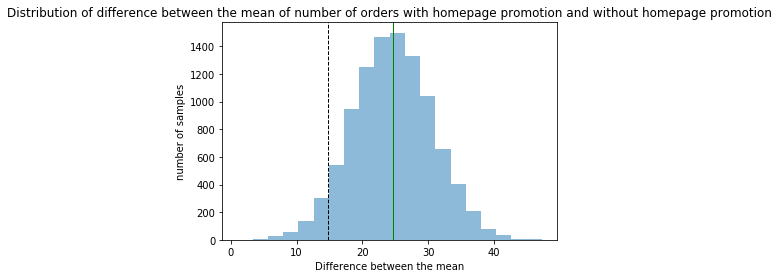

In [10]:
either_activity = dataset[promotion == 1]

homepage_orders = either_activity[either_activity.homepage_featured == 1]['num_orders']
non_homepage_orders = either_activity[either_activity.homepage_featured == 0]['num_orders']

observed_mean_diff = homepage_orders.mean() - non_homepage_orders.mean()
mean_diff_bootstrap = draw_samples(homepage_orders) - draw_samples(non_homepage_orders)

confidence_interval = np.percentile(mean_diff_bootstrap, [5.0])
p_value = np.sum(mean_diff_bootstrap <= 0)/ len(mean_diff_bootstrap)

print("Observed mean difference: {}".format(observed_mean_diff))
print("Confidence Intervals: {}".format(confidence_interval))
print("P-value: {}".format(p_value))

# Plotting histogram
_ = plt.hist(mean_diff_bootstrap, bins=20, alpha=0.5)
_ = plt.xlabel("Difference between the mean")
_ = plt.ylabel("number of samples")
_ = plt.title("Distribution of difference between the mean of number of orders with homepage promotion and without homepage promotion")

# Marking the 5% confidence interval
_ = plt.axvline(confidence_interval[0], color='k', linestyle='dashed', linewidth=1)
_ = plt.axvline(observed_mean_diff, color='g', linewidth=1)

plt.show()

<p>The P-value of above hypothesis test is statistically significant for given left-side 0.05 alpha. Hence, we reject the null hypothesis and accept the alternative hypothesis.</p>
<p>The above Histogram also supports alternate hypothesis.</p>
<p><b><i>Conclusion:</i> Promotion Activity in homepage has more impact than emails on increase in number of orders</b></p>
<p><i>Note: This is only in case were there is any one activity.</i>

# Summary

1. The checkout price and base price has high positive correlation with each other
2. They also have negative correlation with number of orders
3. The operating area and discount has low positive correlation with other variables
4. Promotion Activity by emails does increase the number of orders
5. Promotion Activity in homepage does increase the number of orders
6. But Promotion activity in homepage has more impact than emails on increase in number of orders